# DistilBERT for topic classification
First, load the necessary libraries:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizerFast
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import json
from collections import Counter
import random
import matplotlib.pyplot as plt

### Preparation and balancing of the dataset

Initial counts of non-null probabilities for each label:
Counter({'Health': 26, 'Entertainment': 22, 'Nature': 21, 'Government': 19, 'Technology': 18, 'Concepts': 18, 'Sports': 16, 'Entities': 16, 'History': 16, 'Society': 16, 'Knowledge': 15, 'Science': 15, 'Language': 15, 'Military': 14, 'Culture': 14, 'Time': 14, 'Mathematics': 13, 'Engineering': 13, 'Mass_media': 13, 'Information': 13, 'Geography': 12, 'Life': 12, 'Academic_disciplines': 12, 'Human_behavior': 11, 'Business': 11, 'Politics': 11, 'Economy': 10, 'Internet': 10, 'Religion': 10, 'Philosophy': 10, 'Food_and_drink': 9, 'Education': 9, 'Law': 8, 'Energy': 8, 'People': 8, 'Universe': 7, 'Humanities': 7, 'Communication': 5, 'Ethics': 3})


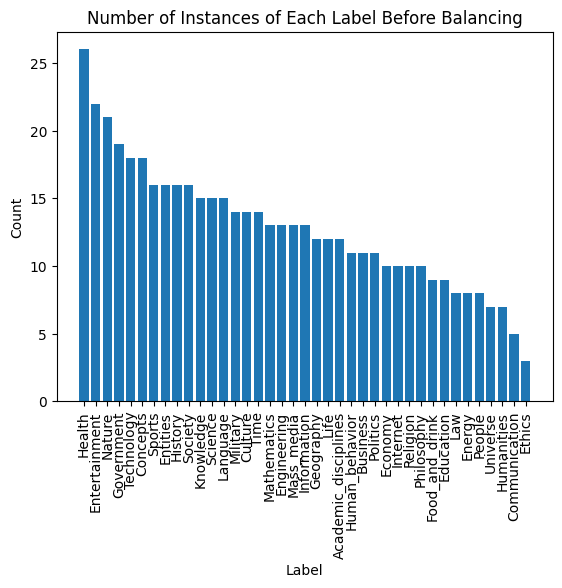

Final counts of non-null probabilities for each label after balancing:
Counter({'Health': 141, 'Entertainment': 137, 'Nature': 136, 'Government': 134, 'Concepts': 133, 'Technology': 133, 'Society': 131, 'History': 131, 'Sports': 131, 'Entities': 131, 'Science': 130, 'Knowledge': 130, 'Language': 130, 'Culture': 129, 'Military': 129, 'Time': 129, 'Mathematics': 128, 'Mass_media': 128, 'Engineering': 128, 'Information': 128, 'Life': 127, 'Academic_disciplines': 127, 'Geography': 127, 'Business': 126, 'Politics': 126, 'Human_behavior': 126, 'Philosophy': 125, 'Economy': 125, 'Internet': 125, 'Religion': 125, 'Education': 124, 'Food_and_drink': 124, 'Energy': 123, 'Law': 123, 'People': 123, 'Humanities': 122, 'Universe': 122, 'Communication': 120, 'Ethics': 118})


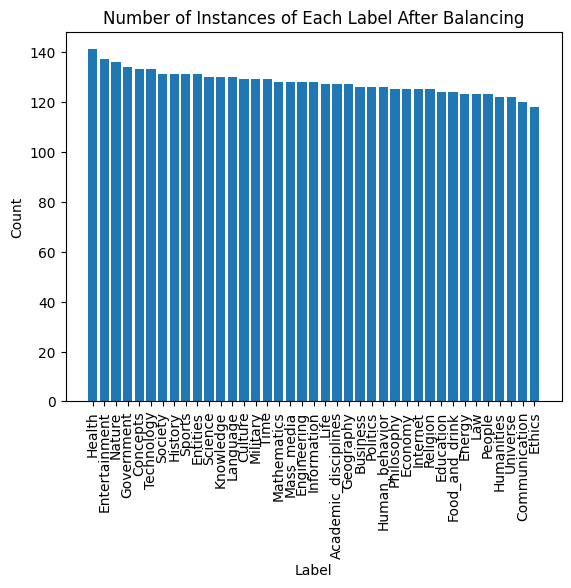

In [ ]:
def load_data(file_path):
    data = pd.read_parquet(file_path)
    return data

def decode_topics(topics_bytes):
    return json.loads(topics_bytes.decode('utf-8'))

def preprocess_data(data):
    data['topics_with_percentages'] = data['topics_with_percentages'].apply(decode_topics)
    return data

def split_data(data):
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    return train_df, test_df

data_path = '/content/drive/MyDrive/GenericMixOfTopic.parquet'
data = load_data(data_path)
data = data.sample(frac=1).reset_index(drop=True)

# BALANCING THE DATASET
# Load the data
df = data

def filter_data_for_probability_one(data):
    # Filter out only rows where at least one label has a probability of 1
    def has_probability_one(topics):
        return any(prob == 1 for prob in topics.values())

    return data[data['topics_with_percentages'].apply(has_probability_one)]

# Decode the topics_with_percentages column
def decode_topics(topics_bytes):
    return json.loads(topics_bytes.decode('utf-8'))

df['topics_with_percentages'] = df['topics_with_percentages'].apply(decode_topics)
df = filter_data_for_probability_one(df)

# Set the desired number of entries
N = 5000

# Step 2: Randomly downsample the dataset to have less random samples
downsampled_df = df.sample(n=N//10, random_state=42)
downsampled_df.reset_index(drop=True, inplace=True)

# Step 3: Count the occurrences of non-null probabilities for each label
def count_non_null_probabilities(df):
    counts = Counter()
    for topics in df['topics_with_percentages']:
        for topic, prob in topics.items():
            if prob > 0:
                counts[topic] += 1
    return counts

initial_counts = count_non_null_probabilities(downsampled_df)
print("Initial counts of non-null probabilities for each label:")
print(initial_counts)

# Plot the initial distribution
initial_labels, initial_counts_values = zip(*sorted(initial_counts.items(), key=lambda item: item[1], reverse=True))
plt.bar(initial_labels, initial_counts_values)
plt.title('Number of Instances of Each Label Before Balancing')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Step 4: Take samples with probability of 1 for each label
def get_samples_with_high_probability(df, label, sample_size):
    high_prob_samples = df[df['topics_with_percentages'].apply(lambda x: x.get(label, 0) == 1)]
    return high_prob_samples.sample(n=sample_size, replace=True, random_state=42)

# Create a new balanced dataframe
balanced_df = downsampled_df.copy()

# Calculate the remaining number of samples needed
remaining_samples_needed = N - len(balanced_df)

# Distribute the remaining samples among the rare labels first
rare_labels = [label for label, count in sorted(initial_counts.items(), key=lambda item: item[1])]

# Calculate the number of samples to be added per label
label_sample_size = max(remaining_samples_needed // len(rare_labels), 1)

# Step 5: Take additional samples for rare labels until N entries are reached
for label in rare_labels:
    if remaining_samples_needed <= 0:
        break
    samples = get_samples_with_high_probability(df, label, min(remaining_samples_needed, label_sample_size))
    balanced_df = pd.concat([balanced_df, samples])
    remaining_samples_needed -= len(samples)

# Ensure we do not exceed N entries
if len(balanced_df) > N:
    balanced_df = balanced_df.sample(n=N, random_state=42)
else:
    balanced_df = balanced_df.sample(n=len(balanced_df), random_state=42)

balanced_df.reset_index(drop=True, inplace=True)

# Verify the counts after balancing
final_counts = count_non_null_probabilities(balanced_df)
print("Final counts of non-null probabilities for each label after balancing:")
print(final_counts)

# Visualize the new distribution
final_labels, final_counts_values = zip(*sorted(final_counts.items(), key=lambda item: item[1], reverse=True))
plt.bar(final_labels, final_counts_values)
plt.title('Number of Instances of Each Label After Balancing')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

data = balanced_df
#data = preprocess_data(data)

train_df, test_df = split_data(data)

def prepare_labels(df):
    topics = set()
    for item in df['topics_with_percentages']:
        topics.update(item.keys())
    topics = list(topics)

    label_data = []
    for item in df['topics_with_percentages']:
        label_dict = {topic: 0.0 for topic in topics}
        for topic, percentage in item.items():
            label_dict[topic] = percentage
        label_data.append(label_dict)

    labels_df = pd.DataFrame(label_data)
    df = df.drop(columns=['topics_with_percentages'])
    df = pd.concat([df, labels_df], axis=1)

    return df, topics

train_df, topics = prepare_labels(train_df)
test_df, _ = prepare_labels(test_df)
train_df = train_df.dropna()
test_df = test_df.dropna()

# Ensure all label columns are of float type
label_columns = topics
train_df[label_columns] = train_df[label_columns].astype(float)
test_df[label_columns] = test_df[label_columns].astype(float)

In [ ]:
train_df

,id,title,topic,text,Entertainment,Time,Science,Life,Academic_disciplines,Politics,...,Humanities,Energy,Language,Food_and_drink,Health,Military,Knowledge,Government,Philosophy,Mathematics
1448,37771322,Eumastacidae,Life,Eumastacidae are a family of grasshoppers so...,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2413,374964,Dendrology,Academic_disciplines,"Dendrology ( , dendron, &quot;tree&quot;; an...",0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,28281563,Rail transport in Saudi Arabia,Universe,Rail transport in Saudi Arabia is an expandi...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3610,634333,Socket 8,Technology,The Socket 8 CPU socket was used exclusively...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1818,53806246,List of churches on the Isle of Man,Religion,The following is a list of churches in the I...,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,24488097,Glabrocyphella,Life,'Glabrocyphella' is a genus of fungi in the ...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466,48945580,Panhumanism,Ethics,Panhumanism is the concept of an affiliation...,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3092,52835421,Zavarzin,Language,"Zavarzin ( ) is a Russian masculine surname, ...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3772,8006675,Pointe Vele Airport,Universe,Pointe Vele Airport is an airport serving Fu...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Architecture of the model

In [ ]:
class DistilBertRegressor(nn.Module):
    def __init__(self, transformer_model_name, num_labels):
        super(DistilBertRegressor, self).__init__()
        self.transformer = DistilBertModel.from_pretrained(transformer_model_name)
        self.regressor = nn.Sequential(
            nn.Linear(self.transformer.config.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_labels),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        transformer_outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = transformer_outputs.last_hidden_state[:, 0, :]
        outputs = self.regressor(hidden_state)
        return outputs

### Training function

In [ ]:
def train_model(model, train_data, val_data, tokenizer, epochs=3, batch_size=16, learning_rate=5e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_texts = train_data['text'].tolist()
    train_labels = train_data[label_columns].values

    val_texts = val_data['text'].tolist()
    val_labels = val_data[label_columns].values

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(train_encodings['input_ids']),
        torch.tensor(train_encodings['attention_mask']),
        torch.tensor(train_labels, dtype=torch.float32)
    )

    val_dataset = torch.utils.data.TensorDataset(
        torch.tensor(val_encodings['input_ids']),
        torch.tensor(val_encodings['attention_mask']),
        torch.tensor(val_labels, dtype=torch.float32)
    )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

def evaluate_model(model, test_data, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_texts = test_data['text'].tolist()
    test_labels = test_data[label_columns].values

    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

    test_dataset = torch.utils.data.TensorDataset(
        torch.tensor(test_encodings['input_ids']),
        torch.tensor(test_encodings['attention_mask']),
        torch.tensor(test_labels, dtype=torch.float32)
    )

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

    model.eval()
    total_test_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

### Training phase

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Define model
num_labels = len(topics)
model = DistilBertRegressor("distilbert-base-uncased", num_labels)

# Train model
train_model(model, train_df, test_df, tokenizer, epochs=3, batch_size=16, learning_rate=1e-3)

# Evaluate model
evaluate_model(model, test_df, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1, Train Loss: 0.03418926318176091, Validation Loss: 0.025210353412798474
Epoch 2, Train Loss: 0.025068345852196215, Validation Loss: 0.025046651251614094
Epoch 3, Train Loss: 0.025044456757605076, Validation Loss: 0.02502117385821683


### Example of predictions vs true labels

In [ ]:
import random

def visualize_predictions(model, tokenizer, data, num_samples=5):
    model.eval()

    samples = random.sample(range(len(data)), num_samples)

    for i in samples:
        text = data.iloc[i]['text']
        true_percentages = data.iloc[i][label_columns].to_dict()

        # Tokenize the input text
        inputs = tokenizer(text, truncation=True, padding=True, max_length=512, return_tensors="pt")

        # Move tensors to the appropriate device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)

        predicted_percentages = {label: float(outputs[0][j]) for j, label in enumerate(label_columns)}

        print(f"Text: {text}")
        print(f"True Percentages: {true_percentages}")
        print(f"Predicted Percentages: {predicted_percentages}")
        print("\n")

# Visualize predictions
visualize_predictions(model, tokenizer, test_df)

Text:   infobox war faction |name |war the Russian Revolution of 1905 and Finnish Civil War |image |caption A Red Guard fighter (right) and a nurse (left) in 1918 |active |ideology |leaders |clans |headquarters |area Finland ( FSWR ), East Karelia |size |partof |predecessor |successor |allegiance Finnish Socialist Workers' Republic |allies Red Guards (Russia)|Russian Red Guards &lt;br /> |opponents (1905–1907) White Guard (Finland)|Protection Corps (1905–1906) Finland (1918) White Guard (Finland)|White Guards (1917–1920) (1918) |battles Russian Revolution of 1905 Finnish Civil War Estonian War of Independence Heimosodat|Kinship Wars The Red Guards ( , ; ) were the paramilitary units of the Finland|Finnish labour movement in the early 1900s. The first Red Guards were established during the 1905 Finnish general strike of 1905|general strike , but disbanded a year later. After the Russian Empire|Russian 1917 February revolution the Red Guards were re-established and in the 1918 Finnish Ci